In [2]:
import MySQLdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [26]:
con = MySQLdb.connect(host='relational.fit.cvut.cz', user='guest', passwd='relational', db='imdb_ijs', port=3306 )
cur = con.cursor()


### Gêneros Comedia x Drama

In [30]:
# Para rodar essas consultas é necessário gerar um dump da base no local (https://relational.fit.cvut.cz/dataset/IMDb)
comedia = cur.execute("SELECT roles.actor_id,  roles.movie_id, movies.name, movies_genres.genre, movies.rank from roles inner join movies_genres on roles.movie_id = movies_genres.movie_id inner join movies on movies.id = roles.movie_id where `rank` is not null and genre = 'Comedy' group by roles.movie_id order by roles.actor_id;")   
comedia = pd.DataFrame(cur.fetchall(), columns=['ator_id','movie_id', 'movie_name', 'genero', 'imdb'])
comedia = comedia.dropna()


In [8]:
drama = cur.execute("SELECT roles.actor_id,  roles.movie_id, movies.name, movies_genres.genre, movies.rank from roles inner join movies_genres on roles.movie_id = movies_genres.movie_id inner join movies on movies.id = roles.movie_id where `rank` is not null and genre = 'Drama' group by roles.movie_id order by roles.actor_id;")   
drama = pd.DataFrame(cur.fetchall(), columns=['ator_id','movie_id', 'movie_name', 'genero', 'imdb'])
drama = drama.dropna()


### Média por gêneros

In [9]:
## Comedia
df3 = comedia
df3 = df3.groupby(df3.ator_id).imdb.mean()

df4 = drama
df4 = df4.groupby(df4.ator_id).imdb.mean()

df3 = df3.reset_index()
df4 = df4.reset_index()


In [10]:
cd = pd.merge(df3, df4, on='ator_id')
cd.columns = ['ator_id', 'avg_comedia', 'avg_drama']

In [11]:
cd

,ator_id,avg_comedia,avg_drama
0,18,6.7,5.4
1,20,5.3,5.3
2,41,8.5,8.5
3,70,6.2,5.9
4,73,6.4,6.4
...,...,...,...
4593,552853,6.6,6.6
4594,587945,7.2,7.2
4595,697662,7.4,5.2
4596,700186,4.3,4.3


In [12]:
X = cd[['avg_comedia','avg_drama']].values

## Agrupamento

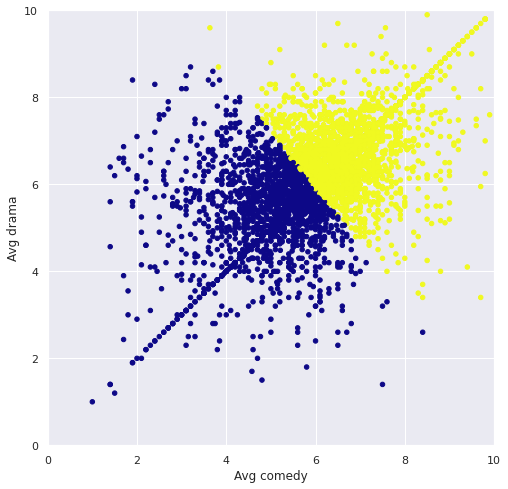

In [13]:
from sklearn.cluster import KMeans

# Instância de Kmeans
kmeans_1 = KMeans(n_clusters=2, random_state=42)

# Instânciando o Agrupamento
predictions = kmeans_1.fit_predict(X)

# Plotando o Agrupamento
draw_clusters(cd, predictions)

## Agrupamento em 3 Grupos

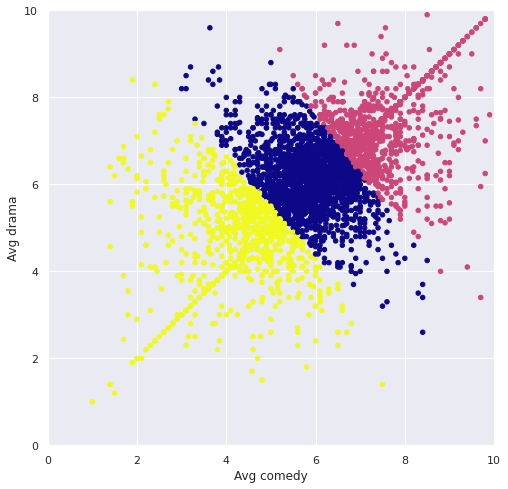

In [14]:
from sklearn.cluster import KMeans

# Instância de Kmeans
kmeans_1 = KMeans(n_clusters=3, random_state=42)

# Instânciando o Agrupamento
predictions = kmeans_1.fit_predict(X)

# Plotando o Agrupamento
draw_clusters(cd, predictions)



### Gênero de Ação

In [15]:
action = cur.execute("SELECT roles.actor_id,  roles.movie_id, movies.name, movies_genres.genre, movies.rank from roles inner join movies_genres on roles.movie_id = movies_genres.movie_id inner join movies on movies.id = roles.movie_id where `rank` is not null and genre = 'Action' group by roles.movie_id order by roles.actor_id;")   
action = pd.DataFrame(cur.fetchall(), columns=['ator_id','movie_id', 'movie_name', 'genero', 'imdb'])
action = action.dropna()
copy = cd

In [16]:
df5 = action
df5 = df5.groupby(df5.ator_id).imdb.mean()

df5 = df5.reset_index()

In [17]:
cp = pd.merge(copy, df5, on='ator_id')
cp.columns = ['ator_id', 'avg_comedia', 'avg_drama', 'avg_action']
cp

,ator_id,avg_comedia,avg_drama,avg_action
0,92,6.1,6.34,7.00
1,94,7.4,4.75,4.20
2,115,4.7,4.50,4.90
3,122,4.4,6.70,5.95
4,144,5.3,5.30,4.30
...,...,...,...,...
1067,284650,6.6,6.60,6.30
1068,305531,3.7,6.70,6.40
1069,403291,5.6,5.60,5.60
1070,461209,6.3,6.30,6.30


In [18]:
X_with_action = cp[['avg_comedia','avg_drama','avg_action']].values

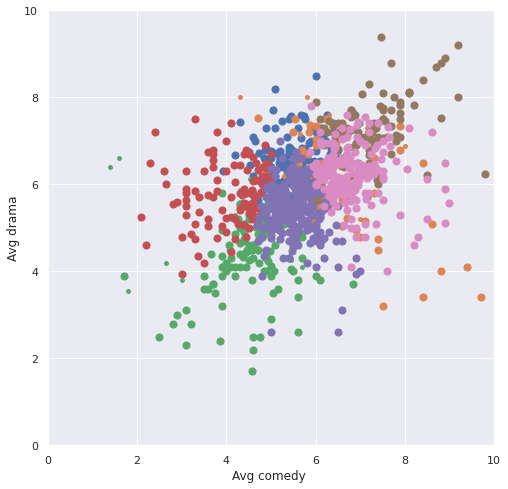

In [19]:
import itertools

kmeans_5 = KMeans(n_clusters=7)
predictions_5 = kmeans_5.fit_predict(X_with_action)

# plot
draw_clusters_3d(cp, predictions_5)

## Funções de Plotagem

In [20]:
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 10)
    plt.ylim(0, 10)
    ax.set_xlabel('Avg comedy ')
    ax.set_ylabel('Avg drama')

    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action'].astype(float) > 3: 
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_comedia'], 
                        point['avg_drama'], 
                        s=size, 
                        color=color)

In [21]:


def draw_clusters(biased_dataset, predictions, cmap='plasma'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    ax.set_xlabel('Avg comedy')
    ax.set_ylabel('Avg drama')
    
    
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_comedia'], clustered['avg_drama'], c=clustered['group'], s=20, cmap=cmap)
    